### 1. Import Dependecies

In [1]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import Tuple, Dict, List

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)

### 2. PCA via Covariance Eigendecomposition

In [2]:
# Load data
df = pd.read_csv('../data/processed/CountryData_Preprocessed.csv')
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.287660,-1.134867,0.278251,-0.082208,-0.805822,0.156864,-1.614237,1.897176,-0.677143
1,-0.537333,-0.478220,-0.096725,0.070624,-0.374243,-0.311411,0.645924,-0.857394,-0.484167
2,-0.272015,-0.098824,-0.963176,-0.639838,-0.220182,0.786908,0.668413,-0.038289,-0.463980
3,2.001787,0.773056,-1.443729,-0.164820,-0.583289,1.382894,-1.175698,2.121770,-0.514720
4,-0.693548,0.160186,-0.286034,0.496076,0.101427,-0.599944,0.702147,-0.540321,-0.041692


Steps to implement PCA:
1. Standarize the data 
2. Compute Covariance Matrix
3. Computer Eigen Values
4. Project data into principal components

In [10]:
def compute_pca_cov(X_std: np.ndarray, k: int = 4) -> Dict:
    n, m = X_std.shape 

    cov_matrix = np.cov(X_std.T)

    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix) 

    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[idx]

    principal_components = eigenvectors[:, :k].T 

    scores = X_std @ principal_components.T 

    total_variance = np.sum(eigenvalues)
    explained_variance = eigenvalues[:k]
    explained_ratio = explained_variance / total_variance
    explained_cum = np.cumsum(explained_ratio)

    print(f"PCA via Covariance Matrix:")
    print(f"  Data shape: {X_std.shape}")
    print(f"  Components shape: {principal_components.shape}")
    print(f"  Scores shape: {scores.shape}")
    print(f"  Explained variance ratio (k={k}): {explained_ratio}")
    print(f"  Cumulative explained variance: {explained_cum}")
    
    return {
            'components': principal_components,
            'scores': scores,
            'eigenvalues': eigenvalues,
            'explained_variance': explained_variance,
            'explained_ratio': explained_ratio,
            'explained_cum': explained_cum,
            'total_variance': total_variance
            }

def top_loadings(components: np.ndarray, feature_names: List[str], top_n: int = 10) -> Dict:
    """
    Find top positive and negative loadings for each principal component.
    """
    results = {}

    for i, pc in enumerate(components):
        abs_loadings = np.abs(pc) # contribution == loadings
        top_indices = np.argsort(abs_loadings)[::-1][:top_n]

        pos_loadings = [(feature_names[j], pc[j]) for j in top_indices if pc[j] > 0]
        neg_loadings = [(feature_names[j], pc[j]) for j in top_indices if pc[j] < 0]

        results[f"PC{i+1}"] = {
                                'positive': pos_loadings,
                                'negative': neg_loadings
                                }

    return results


In [21]:
X_std = df.values
pca_cov_result = compute_pca_cov(X_std)
scores = pca_cov_result['scores']

PCA via Covariance Matrix:
  Data shape: (167, 9)
  Components shape: (4, 9)
  Scores shape: (167, 4)
  Explained variance ratio (k=4): [0.4595174  0.17181626 0.13004259 0.11053162]
  Cumulative explained variance: [0.4595174  0.63133365 0.76137624 0.87190786]


### 3. Visualization

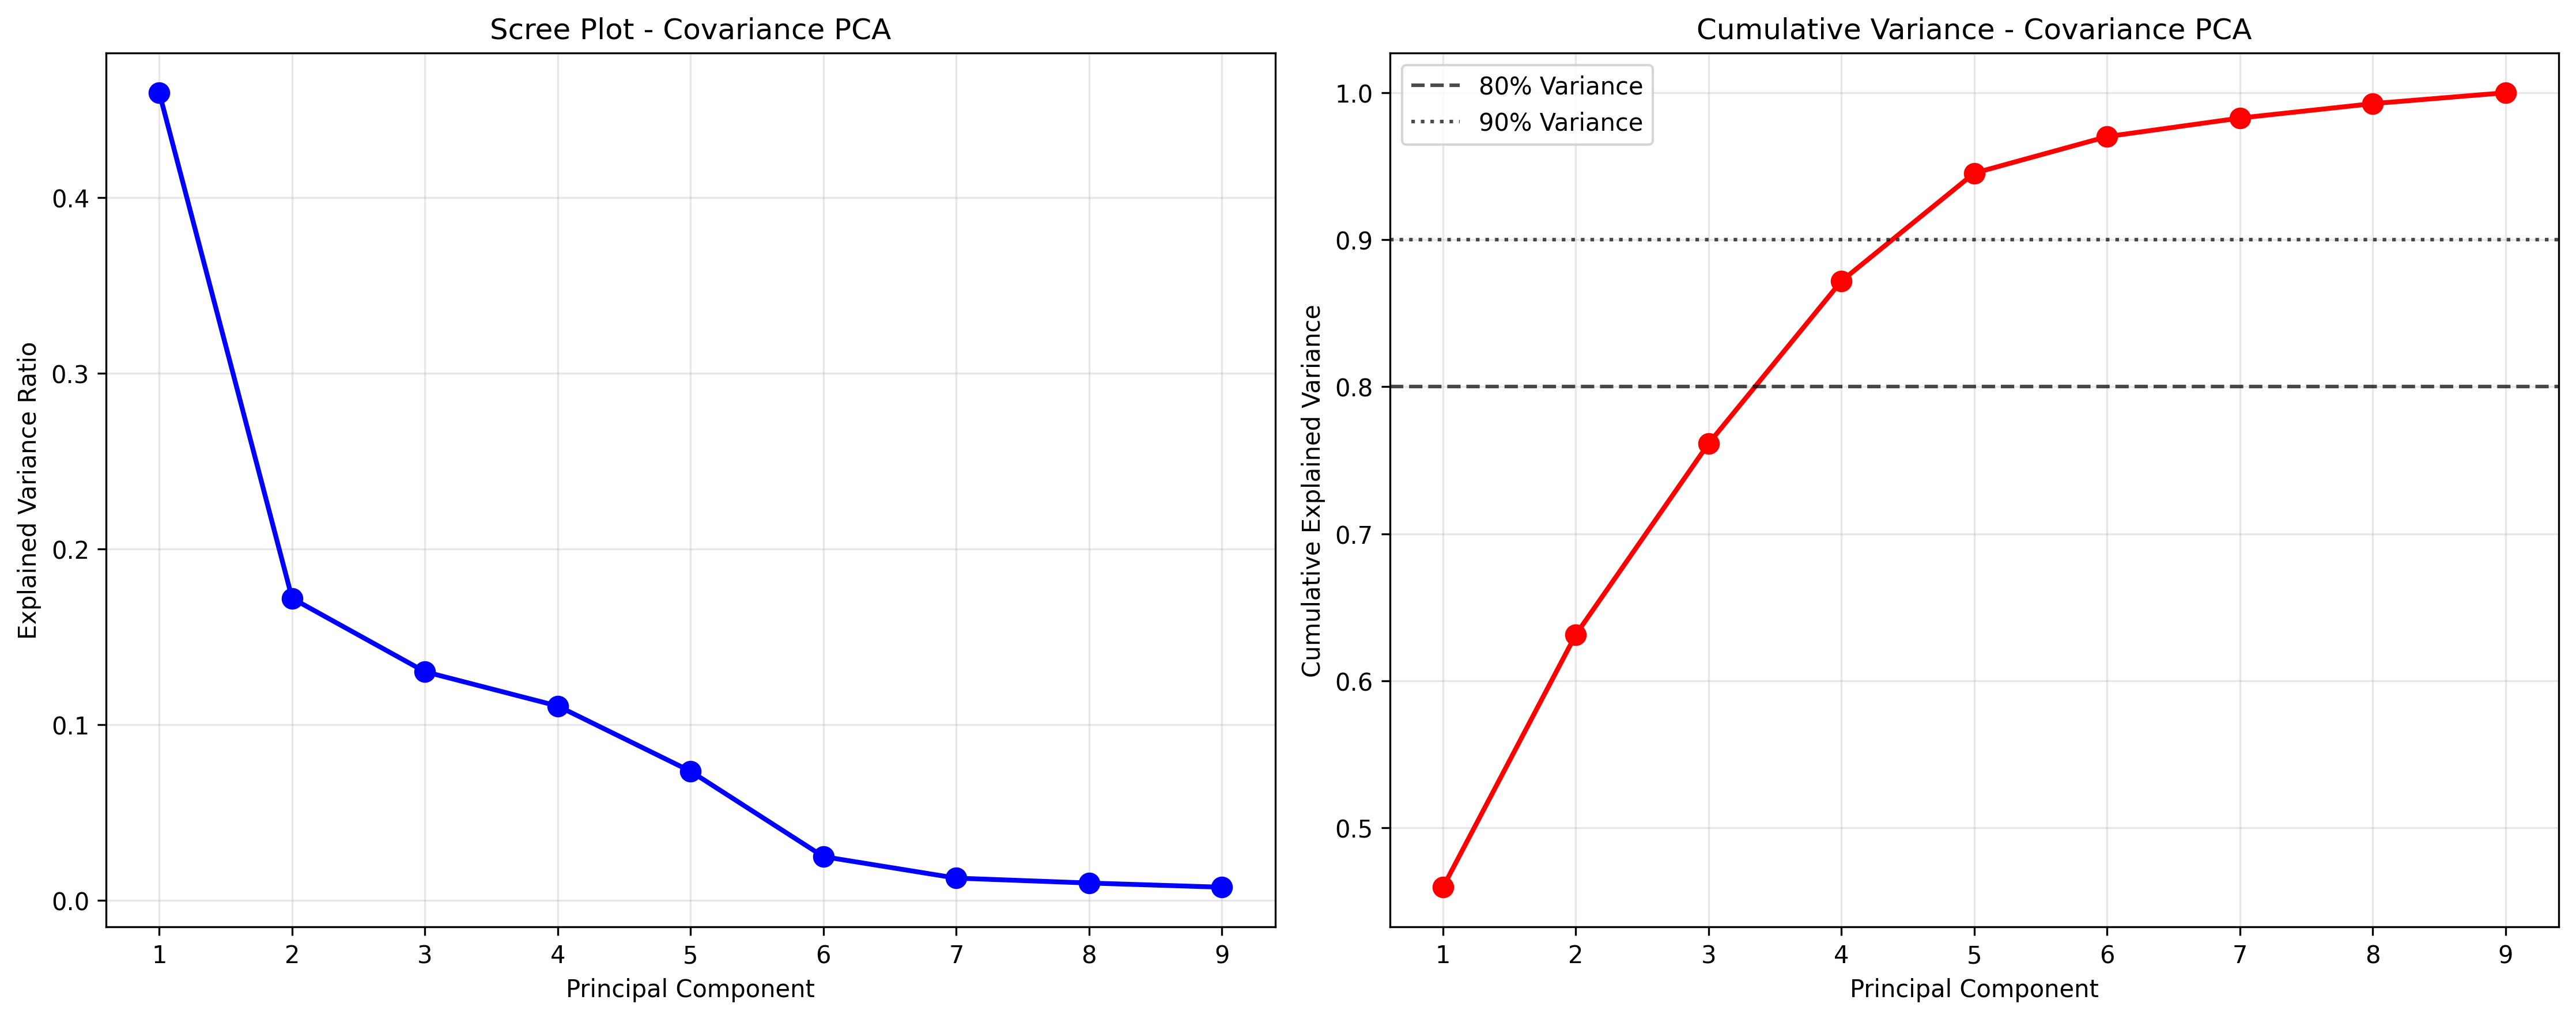

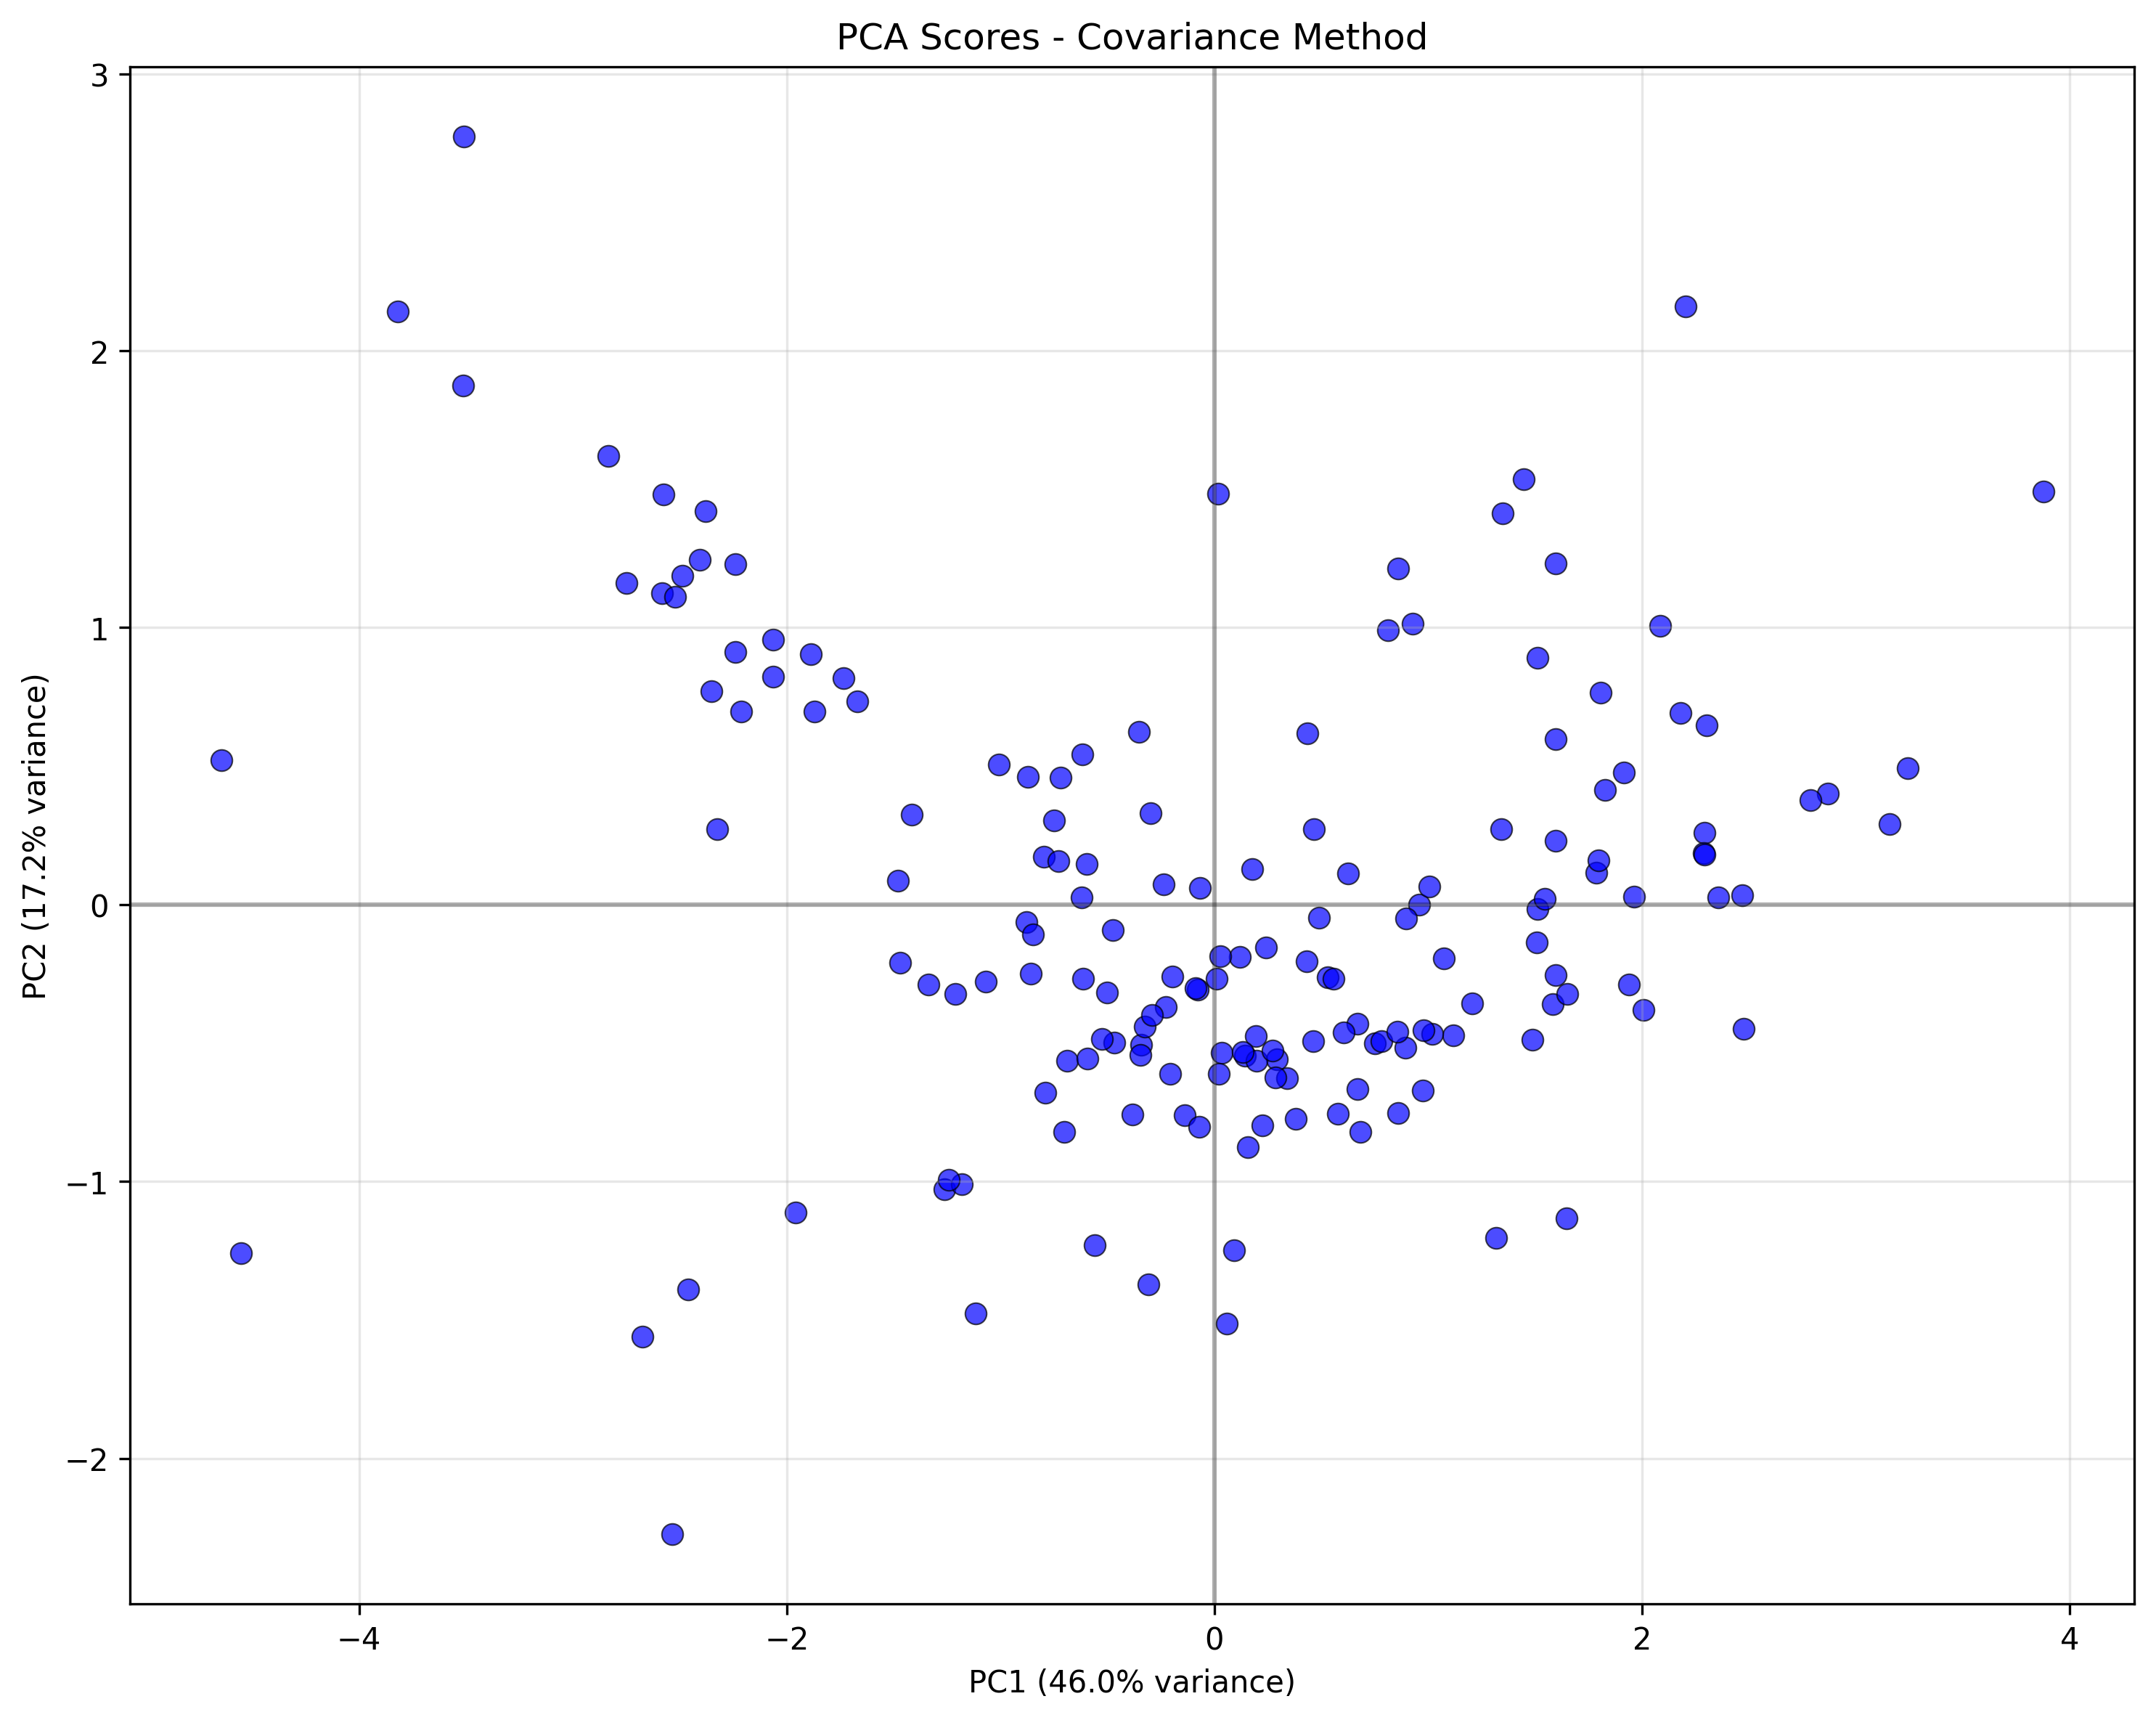

In [20]:
# Plot scree plot and cumulative variance for covariance PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scree plot
eigenvals = pca_cov_result['eigenvalues']
explained_ratios = eigenvals / pca_cov_result['total_variance']
cumulative_ratios = np.cumsum(explained_ratios)

ax1.plot(range(1, len(eigenvals) + 1), explained_ratios, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot - Covariance PCA')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(eigenvals) + 1))

# Cumulative variance plot
ax2.plot(range(1, len(eigenvals) + 1), cumulative_ratios, 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.8, color='k', linestyle='--', alpha=0.7, label='80% Variance')
ax2.axhline(y=0.9, color='k', linestyle=':', alpha=0.7, label='90% Variance')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance - Covariance PCA')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xticks(range(1, len(eigenvals) + 1))

plt.tight_layout()
plt.savefig('../artifacts/figures/pca_cov_scree.png', dpi=300, bbox_inches='tight')
plt.show()

# 2D scatter plot of PC scores
plt.figure(figsize=(10, 8))
plt.scatter(pca_cov_result['scores'][:, 0], pca_cov_result['scores'][:, 1], 
           alpha=0.7, s=50, c='blue', edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({pca_cov_result["explained_ratio"][0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_cov_result["explained_ratio"][1]:.1%} variance)')
plt.title('PCA Scores - Covariance Method')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('../artifacts/figures/pca_cov_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

### 4. Saving new data set

In [22]:
df_pca = pd.DataFrame(scores, columns=[f'pc_{i}' for i in range(scores.shape[1])])
df_pca

,pc_0,pc_1,pc_2,pc_3
0,1.808111,0.764255,-0.592153,-0.306737
1,-0.078296,-0.308491,0.124619,-0.320582
2,0.222983,-0.797755,0.188229,-0.461312
3,2.476413,-0.447791,0.061881,0.062571
4,-0.468081,-0.498966,-0.252816,-0.136022
...,...,...,...,...
162,0.857495,-0.459813,-0.396166,0.036216
163,-0.613740,-0.268060,1.936921,-0.588250
164,0.286254,-0.623849,0.710930,0.970207
165,1.072738,-0.194040,0.187158,-0.287647


In [24]:
df_pca.to_csv('../data/processed/countries_pca_4components.csv', index=False)